# Trip Duration Prediction
The purpose of this modelling is to accurately predict the trip duration of taxi's. To make predictions we will use several algorithms, tune the corresponding parameters of the algorithm by analysisng each parameter against RMSE and predict the trip duration. To make our prediction we use RandomForest Regressor, LinearSVR and LinearRegression.

## How does the pipeline look
1. Loading the data
2. Cleaning the data
3. Training the model
4. Making Predictions
5. Tuning the hyper Parameters to increase Confidence

In [49]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.cluster import KMeans
from matplotlib import style
import pickle
style.use('ggplot')

## Loading the Data

In [5]:
path = 'random_2015.csv'
df = pd.read_csv(path)
df.dropna(inplace=True)

In [6]:
#Getting attributes for EDA
df = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance']]
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['pickup_hrs'] = df['tpep_pickup_datetime'].dt.hour
df['dropoff_hrs'] = df['tpep_dropoff_datetime'].dt.hour
df['day_week'] = df['tpep_pickup_datetime'].dt.weekday
df['tpep_pickup_timestamp'] = (df['tpep_pickup_datetime'] - dt.datetime(1970, 1, 1)).dt.total_seconds()
df['tpep_dropoff_timestamp'] = (df['tpep_dropoff_datetime'] - dt.datetime(1970, 1, 1)).dt.total_seconds() 
df['duration'] = df['tpep_dropoff_timestamp'] - df['tpep_pickup_timestamp']
df['speed'] = (df['trip_distance'] * 3600)//df['duration']

In [7]:
#cleaning for EDA, removing outliers
df = df[ (df['duration'] > 0)]
df = df[ (df['speed'] > 6.0)]
df = df[ (df['speed'] < 140.0)]
df = df[ (df['pickup_longitude'] != 0)]
df = df[ (df['dropoff_longitude'] != 0)]
df = df[ (df['pickup_latitude'] > 38)]
df = df[ (df['pickup_latitude'] < 45)]


In [8]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,pickup_hrs,dropoff_hrs,day_week,tpep_pickup_timestamp,tpep_dropoff_timestamp,duration,speed
0,2015-01-24 18:00:28,2015-01-24 18:10:07,-73.964111,40.761398,-73.977989,40.783093,2.40,18,18,5,1.422122e+09,1.422123e+09,579.0,14.0
1,2015-01-15 04:37:29,2015-01-15 04:58:14,-73.961479,40.760410,-73.943573,40.709702,5.00,4,4,3,1.421297e+09,1.421298e+09,1245.0,14.0
2,2015-01-09 05:14:31,2015-01-09 05:47:16,-73.986893,40.761726,-73.873169,40.774326,10.25,5,5,4,1.420780e+09,1.420782e+09,1965.0,18.0
3,2015-01-29 09:52:05,2015-01-29 10:16:33,-73.965759,40.758114,-74.010399,40.701965,5.46,9,10,3,1.422525e+09,1.422527e+09,1468.0,13.0
4,2015-01-02 02:20:01,2015-01-02 02:27:37,-73.955032,40.821857,-73.950897,40.808399,1.50,2,2,4,1.420165e+09,1.420166e+09,456.0,11.0


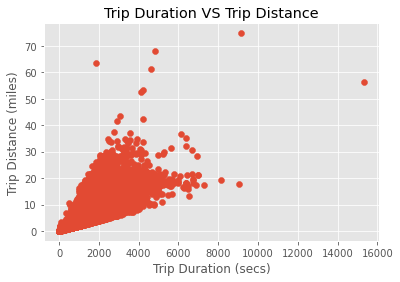

In [9]:
#EDA
plt.scatter(df['duration'], df['trip_distance'])
plt.title('Trip Duration VS Trip Distance')
plt.xlabel('Trip Duration (secs)')
plt.ylabel('Trip Distance (miles)')
plt.show()

Bar Plot taakes lot of time for plotting and analysing other attributes, so Microsoft Power BI was used for analysis


<a href="https://ibb.co/gcrVAm"><img src="https://preview.ibb.co/e4Gxqm/corelation_analysis.png" alt="corelation_analysis" border="0"></a>

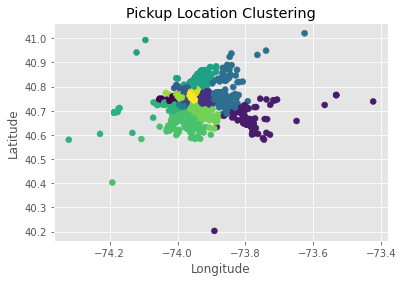

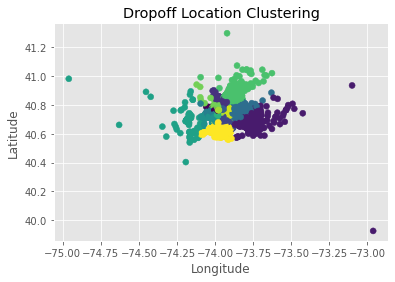

In [10]:
#clustering pickup and dropoff locations
n = len(df)
kmeans_pickup = KMeans(n_clusters = 15, random_state = 2).fit(df[['pickup_latitude', 'pickup_longitude']])
df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude','pickup_longitude']])
plt.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_pickup[:n])
plt.title('Pickup Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

kmeans_dropoff = KMeans(n_clusters = 15, random_state = 2).fit(df[['dropoff_latitude', 'dropoff_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude','dropoff_longitude']])
plt.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_dropoff[:n])
plt.title('Dropoff Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [11]:
#creating dummy variables/one hot encoding, adding features
df = pd.concat([df, pd.get_dummies(df['pickup_hrs'], prefix = 'hrs')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['day_week'], prefix = 'day')], axis = 1)
df['pickup_dropoff_cluster'] = df['kmeans_pickup'].map(str) + 'to' +  df['kmeans_dropoff'].map(str)
df = pd.concat([df, pd.get_dummies(df['pickup_dropoff_cluster'], prefix = 'route')], axis = 1)

In [13]:
##cleaninig df for training containig only features
df.drop(df.columns[[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 47]], axis = 1, inplace = True)

In [14]:
#writing cleaned data to file for post prediction analysis and tuning hyperparameyres for Randomforest
df.to_csv('post_analysis_data.csv')

## Training the model

In [50]:
X = np.array(df.drop(['duration'], axis=1))
y = np.array(df['duration'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Random Forest

In [45]:
clf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, n_jobs=-1)

### Gradient Boosting Regressor

In [46]:
gbrt = GradientBoostingRegressor(n_estimators = 50, learning_rate=0.1, max_depth=3)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=50)

### Support Vector Regression

In [51]:
svm_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_reg.fit(X_train, y_train)

SVR(C=100, degree=2, kernel='poly')

## Making Predictions

In [47]:
accuracy = clf.score(X_test, y_test)
print("Random Forest Regressor Accuracy: {}".format(accuracy))

Random Forest Regressor Accuracy: 0.8268597436498094


In [48]:
accuracy = gbrt.score(X_test, y_test)
print("Gradient Boosting Regressor Accuracy: {}".format(accuracy))

Gradient Boosting Regressor Accuracy: 0.7901902896087986


## Tuning/Analysing the hyperparameters to improve confidence

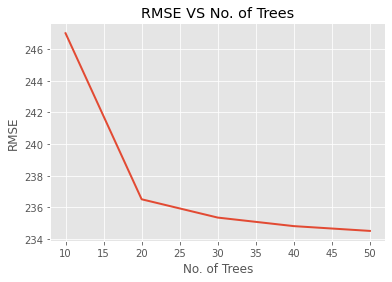

In [19]:
#Analysing the required number of trees for RandomForest
a = np.array([[10, 247]])
for i in range(20, 60, 10):
    clf = RandomForestRegressor(n_estimators = i)
    clf.fit(X_train, y_train)
    y_actual = y_test
    y_pred = clf.predict(X_test)
    rms = sqrt(mean_squared_error(y_actual, y_pred))
    a = np.append(a, [[i, rms]], axis = 0)
    
plt.plot(a[:, 0], a[:, 1], linewidth = 2.0)
plt.title('RMSE VS No. of Trees')
plt.xlabel('No. of Trees')
plt.ylabel('RMSE')
plt.show()